Extracting features of a single star

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # very useful command for high-res images

# invoke pyplot in matplotlib, give it an alias
import matplotlib.pyplot as plt 

import numpy as np
from concurrent.futures import as_completed

import math
import glob
import sys
import os

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')


import pandas as pd

# file_path="/home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_median_after_detrended/_lc_median_after_cbv_detrended_DCE/30316061_sector01_4_1.lc"

file_path="/home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_outliercleaned/ACV/41259805_sector01_4_2_cleaned.lc"

data = np.loadtxt(file_path, delimiter=',')
time = data[:, 0]
mag = data[:, 1]
magerr = data[:, 2]

### here follows your actual code
import warnings
from scipy import stats
from statsmodels.tsa import stattools
from scipy.interpolate import interp1d
from scipy.stats import chi2

def Amplitude(mag):
    n = len(mag)
    sorted_mag = np.sort(mag)
    return (np.median(sorted_mag[int(-math.ceil(0.05 * n)):]) -
            np.median(sorted_mag[0:int(math.ceil(0.05 * n))])) / 2.0

def Rcs(mag):
    sigma = np.std(mag)
    N = len(mag)
    m = np.mean(mag)
    s = np.cumsum(mag - m) * 1.0 / (N * sigma)
    R = np.max(s) - np.min(s)
    return R

def StetsonK(mag, magerr):
    n = len(mag)
    mean_mag = np.sum(mag / (magerr**2)) / np.sum(1.0 / (magerr**2))
    sigmap = (np.sqrt(n / (n - 1)) * (mag - mean_mag) / magerr)
    k = (1 / np.sqrt(n) * np.sum(np.abs(sigmap)) / np.sqrt(np.sum(sigmap ** 2)))
    return k

def Meanvariance(mag):
    return np.std(mag) / np.mean(mag)

def Autocor_length(mag):
    nlags = 100
    ac = stattools.acf(mag, nlags=nlags, fft=False)
    k = next((i for i, v in enumerate(ac) if v < np.exp(-1)), None)
    while k is None:
        if nlags > len(mag):
            warnings.warn('Setting autocorrelation length as light curve length')
            return len(mag)
        nlags += 100
        ac = stattools.acf(mag, nlags=nlags, fft=False)
        k = next((i for i, v in enumerate(ac) if v < np.exp(-1)), None)
    return k

def Con(mag):
    consecutiveStar = 3
    N = len(mag)
    if N < consecutiveStar:
        return 0
    sigma = np.std(mag)
    m = np.mean(mag)
    count = 0
    for i in range(N - consecutiveStar + 1):
        flag = 0
        for j in range(consecutiveStar):
            if mag[i + j] > m + 2 * sigma or mag[i + j] < m - 2 * sigma:
                flag = 1
            else:
                flag = 0
                break
        if flag:
            count += 1
    return count / (N - consecutiveStar + 1)

def Beyond1Std(mag, magerr):
    n = len(mag)
    weighted_mean = np.average(mag, weights=1 / magerr**2)
    var = np.sum((mag - weighted_mean)**2)
    std = np.sqrt(var / (n - 1))
    count = np.sum((mag > weighted_mean + std) | (mag < weighted_mean - std))
    return count / n

def SmallKurtosis(mag):
    n = len(mag)
    mean = np.mean(mag)
    std = np.std(mag)
    S = np.sum(((mag - mean) / std) ** 4)
    c1 = n * (n + 1) / ((n - 1) * (n - 2) * (n - 3))
    c2 = 3 * (n - 1)**2 / ((n - 2) * (n - 3))
    return c1 * S - c2

def Std(mag):
    return np.std(mag)

def Skew(mag):
    return stats.skew(mag)

def MaxSlope(mag, time):
    slope = np.abs(mag[1:] - mag[:-1]) / (time[1:] - time[:-1])
    return np.max(slope)

def MedianAbsDev(mag):
    median = np.median(mag)
    devs = np.abs(mag - median)
    return np.median(devs)

def MedianBRP(mag):
    median = np.median(mag)
    amplitude = (np.max(mag) - np.min(mag)) / 10
    n = len(mag)
    count = np.sum((mag < median + amplitude) & (mag > median - amplitude))
    return count / n

def PairSlopeTrend(mag):
    data_last = mag[-30:]
    return (len(np.where(np.diff(data_last) > 0)[0]) - len(np.where(np.diff(data_last) <= 0)[0])) / 30

def FluxPercentileRatioMid20(mag):
    sorted_data = np.sort(mag)
    n = len(sorted_data)
    return (sorted_data[math.ceil(0.60*n)] - sorted_data[math.ceil(0.40*n)]) / (sorted_data[math.ceil(0.95*n)] - sorted_data[math.ceil(0.05*n)])

def FluxPercentileRatioMid35(mag):
    sorted_data = np.sort(mag)
    n = len(sorted_data)
    return (sorted_data[math.ceil(0.675*n)] - sorted_data[math.ceil(0.325*n)]) / (sorted_data[math.ceil(0.95*n)] - sorted_data[math.ceil(0.05*n)])

def FluxPercentileRatioMid50(mag):
    sorted_data = np.sort(mag)
    n = len(sorted_data)
    return (sorted_data[math.ceil(0.75*n)] - sorted_data[math.ceil(0.25*n)]) / (sorted_data[math.ceil(0.95*n)] - sorted_data[math.ceil(0.05*n)])

def FluxPercentileRatioMid65(mag):
    sorted_data = np.sort(mag)
    n = len(sorted_data)
    return (sorted_data[math.ceil(0.825*n)] - sorted_data[math.ceil(0.175*n)]) / (sorted_data[math.ceil(0.95*n)] - sorted_data[math.ceil(0.05*n)])

def FluxPercentileRatioMid80(mag):
    sorted_data = np.sort(mag)
    n = len(sorted_data)
    return (sorted_data[math.ceil(0.90*n)] - sorted_data[math.ceil(0.10*n)]) / (sorted_data[math.floor(0.95*n)] - sorted_data[math.ceil(0.05*n)])

def PercentDifferenceFluxPercentile(mag):
    median_data = np.median(mag)
    sorted_data = np.sort(mag)
    n = len(sorted_data)
    F_5_95 = sorted_data[math.ceil(0.95*n)] - sorted_data[math.ceil(0.05*n)]
    return F_5_95 / median_data

def PercentAmplitude(mag):
    median_data = np.median(mag)
    return np.max(np.abs(mag - median_data)) / median_data

def LinearTrend(mag, time):
    return stats.linregress(time, mag)[0]

def Eta_e(mag, time):
    w = 1.0 / np.power(np.subtract(time[1:], time[:-1]), 2)
    sigma2 = np.var(mag)
    S1 = np.sum(w * np.power(np.subtract(mag[1:], mag[:-1]), 2))
    S2 = np.sum(w)
    return (1 / sigma2) * (S1 / S2)

def Mean(mag):
    return np.mean(mag)

def Q31(mag):
    percentiles = np.percentile(mag, (25, 75))
    return percentiles[1] - percentiles[0]

def AndersonDarling(mag):
    ander = stats.anderson(mag)[0]
    return 1 / (1.0 + np.exp(-10 * (ander - 0.3)))

def Gskew(mag):
    median_mag = np.median(mag)
    F_3, F_97 = np.percentile(mag, (3, 97))
    return np.median(mag[mag <= F_3]) + np.median(mag[mag >= F_97]) - 2 * median_mag

def StructureFunction_index_21(mag, time):
    return _structure_function_slope(mag, time)[0]

def StructureFunction_index_31(mag, time):
    return _structure_function_slope(mag, time)[1]

def StructureFunction_index_32(mag, time):
    return _structure_function_slope(mag, time)[2]

def _structure_function_slope(mag, time):
    Nsf, Np = 100, 100
    f = interp1d(time, mag)
    time_int = np.linspace(np.min(time), np.max(time), Np)
    mag_int = f(time_int)
    sf1 = np.array([np.mean(np.abs(mag_int[:-tau] - mag_int[tau:])**1.0) for tau in range(1, Nsf)])
    sf2 = np.array([np.mean(np.abs(mag_int[:-tau] - mag_int[tau:])**2.0) for tau in range(1, Nsf)])
    sf3 = np.array([np.mean(np.abs(mag_int[:-tau] - mag_int[tau:])**3.0) for tau in range(1, Nsf)])
    sf1_log, sf2_log, sf3_log = np.log10(np.trim_zeros(sf1)), np.log10(np.trim_zeros(sf2)), np.log10(np.trim_zeros(sf3))
    m_21 = np.polyfit(sf1_log, sf2_log, 1)[0]
    m_31 = np.polyfit(sf1_log, sf3_log, 1)[0]
    m_32 = np.polyfit(sf2_log, sf3_log, 1)[0]
    return m_21, m_31, m_32

def Pvar(mag, magerr):
    mean_mag = np.mean(mag)
    nepochs = float(len(mag))
    chi = np.sum((mag - mean_mag)**2 / magerr**2)
    return chi2.cdf(chi, nepochs - 1)

def ExcessVar(mag, magerr):
    mean_mag = np.mean(mag)
    nepochs = float(len(mag))
    ex_var = np.sum((mag - mean_mag)**2 - magerr**2) / (nepochs * (mean_mag ** 2))
    return ex_var

### if not using feets, store the calculated features in an array

from tabulate import tabulate

# List of feature names and their corresponding values
features = [
    ["Amplitude", Amplitude(mag)],
    ["Rcs", Rcs(mag)],
    ["StetsonK", StetsonK(mag, magerr)],
    ["Meanvariance", Meanvariance(mag)],
    ["Autocor_length", Autocor_length(mag)],
    ["Con", Con(mag)],
    ["Beyond1Std", Beyond1Std(mag, magerr)],
    ["SmallKurtosis", SmallKurtosis(mag)],
    ["Std", Std(mag)],
    ["Skew", Skew(mag)],
    ["MaxSlope", MaxSlope(mag, time)],
    ["MedianAbsDev", MedianAbsDev(mag)],
    ["MedianBRP", MedianBRP(mag)],
    ["PairSlopeTrend", PairSlopeTrend(mag)],
    ["FluxPercentileRatioMid20", FluxPercentileRatioMid20(mag)],
    ["FluxPercentileRatioMid35", FluxPercentileRatioMid35(mag)],
    ["FluxPercentileRatioMid50", FluxPercentileRatioMid50(mag)],
    ["FluxPercentileRatioMid65", FluxPercentileRatioMid65(mag)],
    ["FluxPercentileRatioMid80", FluxPercentileRatioMid80(mag)],
    ["PercentDifferenceFluxPercentile", PercentDifferenceFluxPercentile(mag)],
    ["PercentAmplitude", PercentAmplitude(mag)],
    ["LinearTrend", LinearTrend(mag, time)],
    ["Eta_e", Eta_e(mag, time)],
    ["Mean", Mean(mag)],
    ["Q31", Q31(mag)],
    ["AndersonDarling", AndersonDarling(mag)],
    ["Gskew", Gskew(mag)],
    ["StructureFunction_index_21", StructureFunction_index_21(mag, time)],
    ["StructureFunction_index_31", StructureFunction_index_31(mag, time)],
    ["StructureFunction_index_32", StructureFunction_index_32(mag, time)],
    ["StructureFunction_slope", _structure_function_slope(mag, time)],
    ["Pvar", Pvar(mag, magerr)],
    ["ExcessVar", ExcessVar(mag, magerr)],
]

# Print the table
print(tabulate(features, headers=["Feature", "Value"], tablefmt="grid"))


+---------------------------------+--------------------------------------------------------------+
| Feature                         | Value                                                        |
+=================================+==============================================================+
| Amplitude                       | 0.015901500000000013                                         |
+---------------------------------+--------------------------------------------------------------+
| Rcs                             | 0.0835737660332833                                           |
+---------------------------------+--------------------------------------------------------------+
| StetsonK                        | 0.8302931678855                                              |
+---------------------------------+--------------------------------------------------------------+
| Meanvariance                    | 0.0007308838148783457                                        |
+---------

Saving the feature results as a file

In [2]:
import pandas as pd

# Prepare a dictionary with feature names as keys and values as values
feature_dict = {}

for feature_name, feature_value in features:
    # If the feature_value is a tuple or list (like _structure_function_slope), convert it to string or flatten
    if isinstance(feature_value, (tuple, list, np.ndarray)):
        # Convert to string or flatten the values
        feature_dict[feature_name] = ','.join(map(str, feature_value))
    else:
        feature_dict[feature_name] = feature_value

# Create a DataFrame with a single row
df = pd.DataFrame([feature_dict])

# Save to CSV
output_path = "/home/devika/PhD/S1/Astroinformatics/Project/_data/features_output.csv"
df.to_csv(output_path, index=False)

print(f"Features saved to {output_path}")


Features saved to /home/devika/PhD/S1/Astroinformatics/Project/_data/features_output.csv


Extracting the features of a file

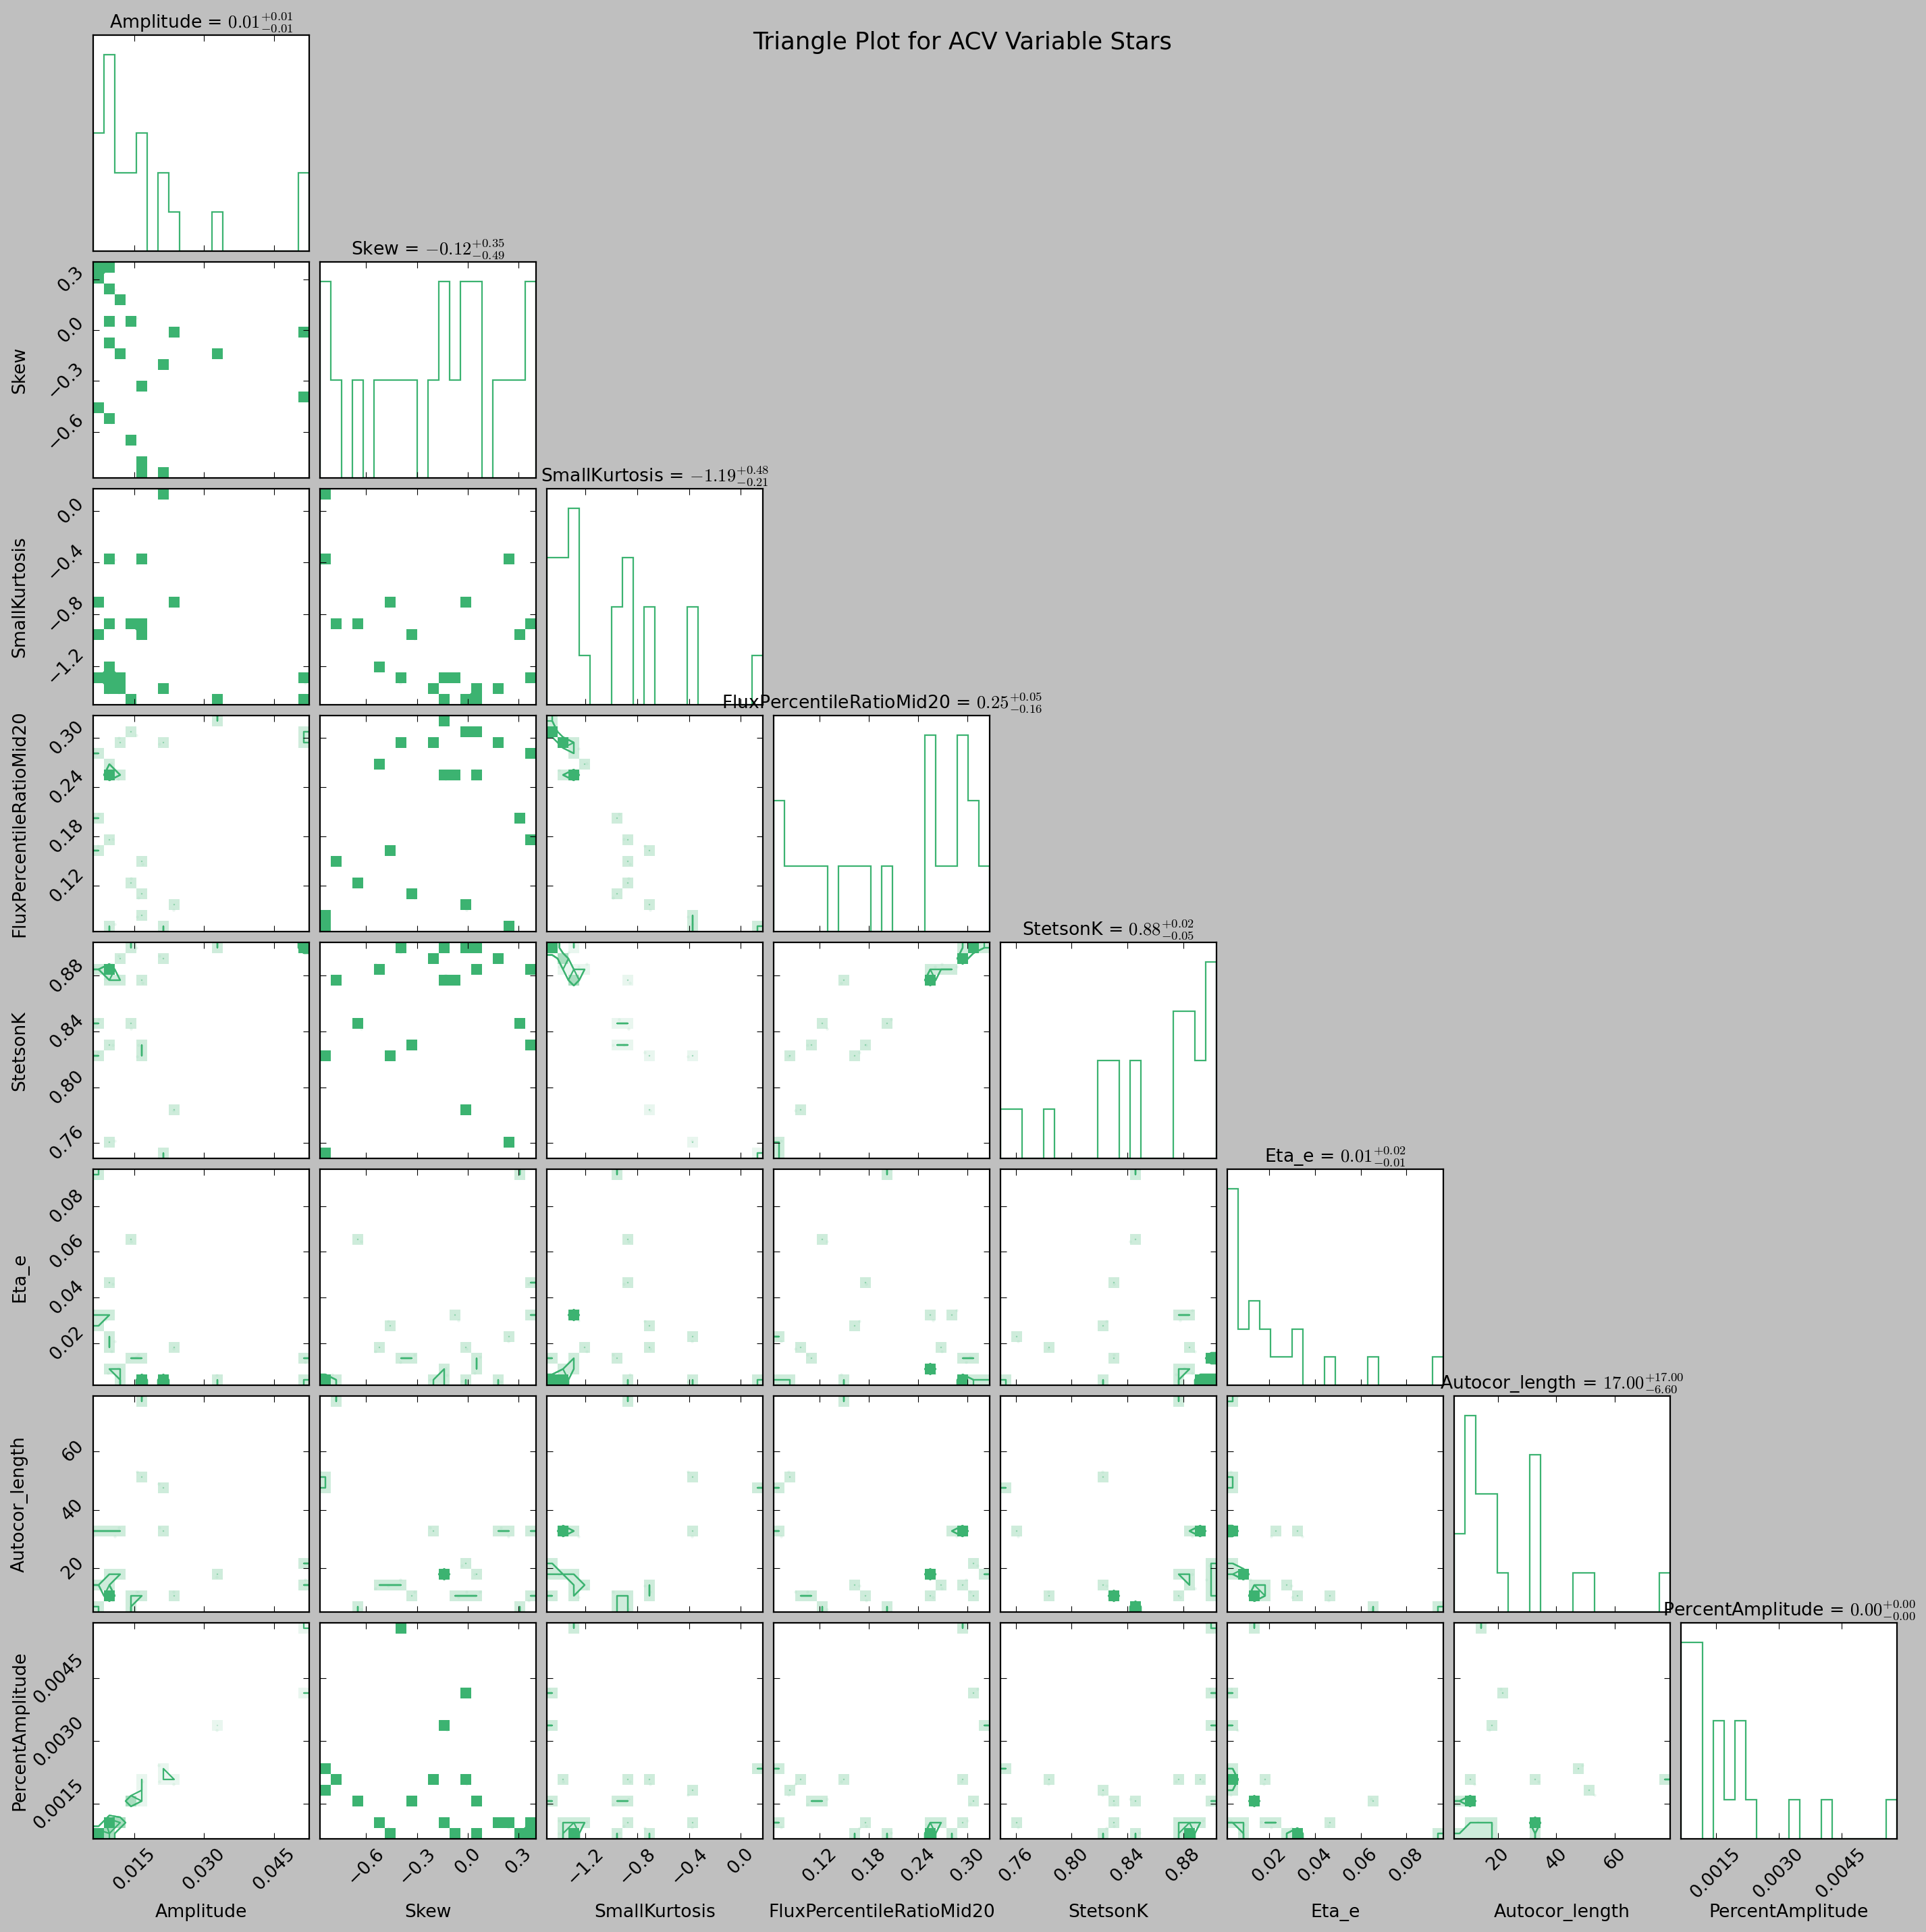

In [8]:
import pandas as pd
import corner
import matplotlib.pyplot as plt

# Path to your full feature table
csv_path = "/home/devika/PhD/S1/Astroinformatics/Project/_data/TESS_outliercleaned_features.csv"

# Load the table
df = pd.read_csv(csv_path)

# Filter by one star type, e.g., ACV
df_acv = df[df["Variable_Type"] == "ACV"]

# Select a subset of meaningful, non-correlated features (adjust as needed)
selected_features = [
    "Amplitude",                          # Overall magnitude range
    "Skew",                               # Light curve asymmetry
    "SmallKurtosis",                      # Peakedness of flux distribution
    "FluxPercentileRatioMid20",          # Shape descriptor (20–80%)
    "StetsonK",                           # Robust variability index
    "Eta_e",                              # Time-series correlation (variability)
    "Autocor_length",                    # Memory in the light curve
    "PercentAmplitude"                   # Peak-to-mean amplitude
]

# Drop rows with NaNs in selected features
data = df_acv[selected_features].dropna()

# Create the triangle plot
fig = corner.corner(
    data,
    labels=selected_features,
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 12},
    color="mediumseagreen"
)

# Show plot
plt.suptitle("Triangle Plot for ACV Variable Stars", fontsize=16)
plt.show()


To create a triangle plot showing the features first for all variable stars from one star type (e.g.: ACV).

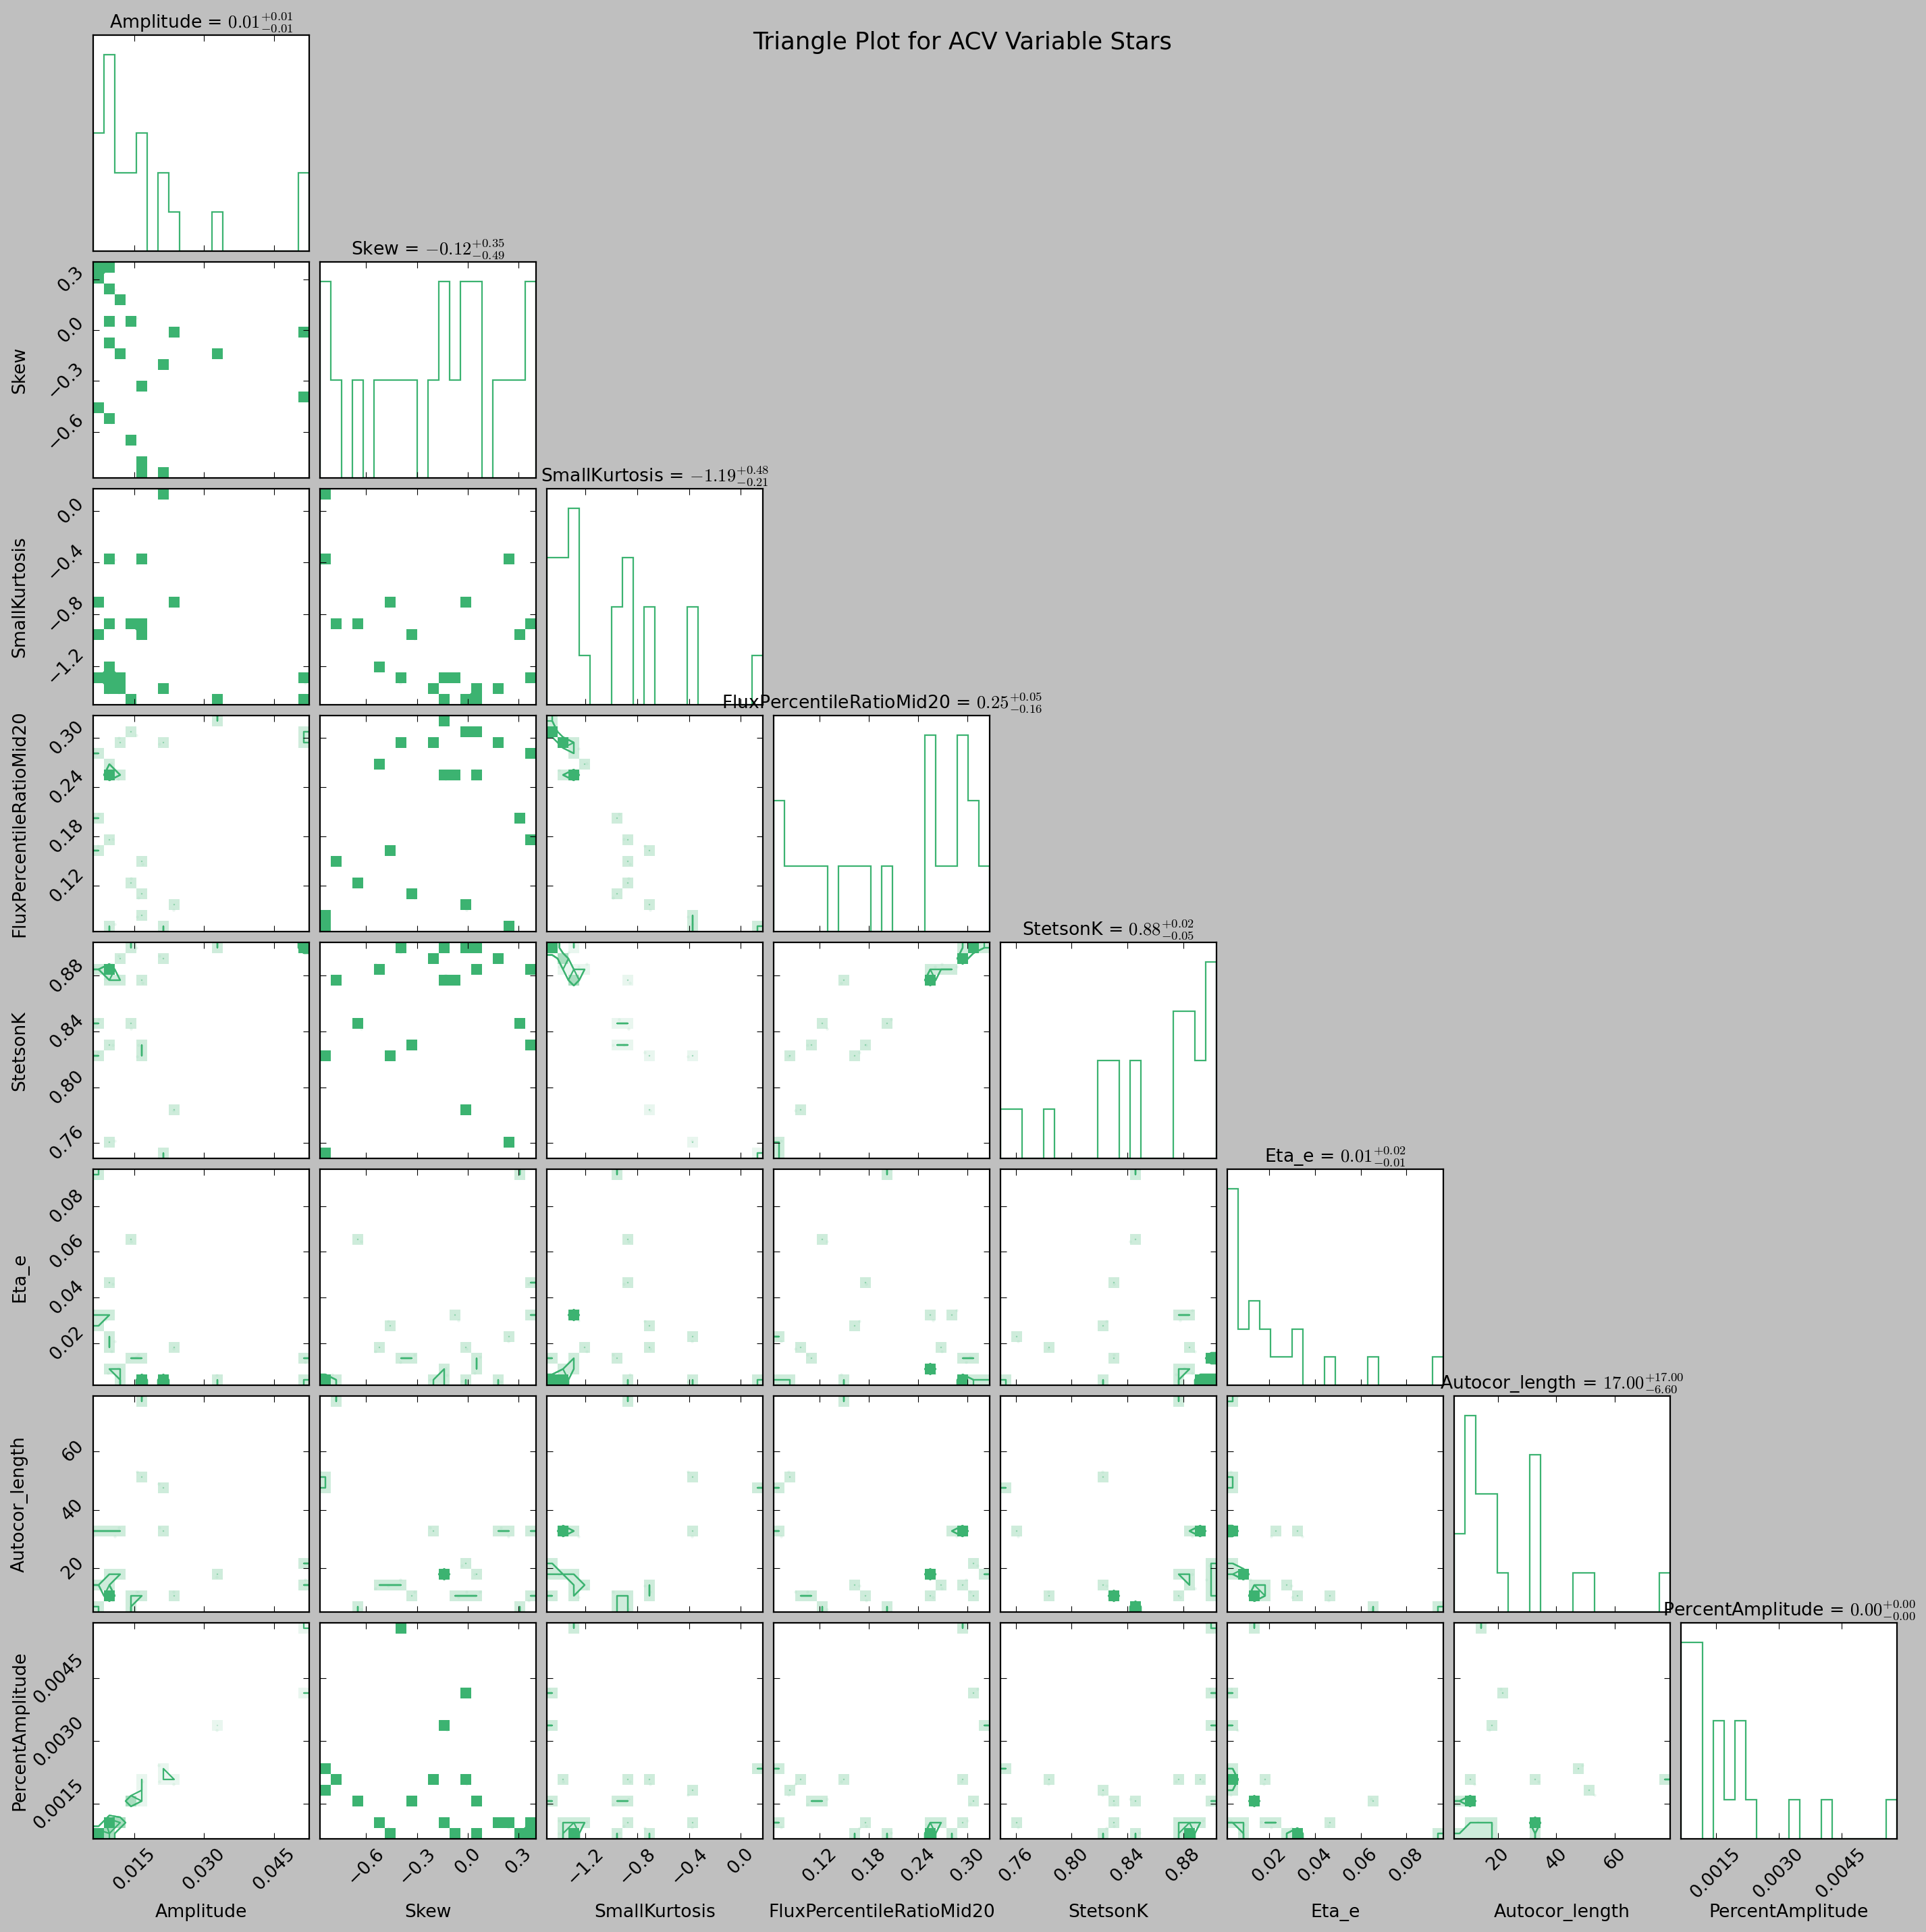

In [4]:
import pandas as pd
import corner
import matplotlib.pyplot as plt

# Path to your full feature table
csv_path = "/home/devika/PhD/S1/Astroinformatics/Project/features/TESS_outliercleaned_features.csv"

# Load the table
df = pd.read_csv(csv_path)

# Filter by one star type, e.g., ACV
df_acv = df[df["Variable_Type"] == "ACV"]

# Select a subset of meaningful, non-correlated features (adjust as needed)
selected_features = [
    "Amplitude",                          # Overall magnitude range
    "Skew",                               # Light curve asymmetry
    "SmallKurtosis",                      # Peakedness of flux distribution
    "FluxPercentileRatioMid20",          # Shape descriptor (20–80%)
    "StetsonK",                           # Robust variability index
    "Eta_e",                              # Time-series correlation (variability)
    "Autocor_length",                    # Memory in the light curve
    "PercentAmplitude"                   # Peak-to-mean amplitude
]

# Drop rows with NaNs in selected features
data = df_acv[selected_features].dropna()

# Create the triangle plot
fig = corner.corner(
    data,
    labels=selected_features,
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 12},
    color="mediumseagreen"
)

# Show plot
plt.suptitle("Triangle Plot for ACV Variable Stars", fontsize=16)
plt.show()


for each type in TESS_outliercleaned file create a triangle plot and save it as a pdf file

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import corner

# Load the feature table
csv_path = "/home/devika/PhD/S1/Astroinformatics/Project/_data/TESS_outliercleaned_features.csv"
df = pd.read_csv(csv_path)

# Choose features to include in triangle plots
selected_features = [
    "Amplitude",                          # Overall magnitude range
    "Skew",                               # Light curve asymmetry
    "SmallKurtosis",                      # Peakedness of flux distribution
    "FluxPercentileRatioMid20",          # Shape descriptor (20–80%)
    "StetsonK",                           # Robust variability index
    "Eta_e",                              # Time-series correlation (variability)
    "Autocor_length",                    # Memory in the light curve
    "PercentAmplitude"                   # Peak-to-mean amplitude
]

# Unique variable types
variable_types = df["Variable_Type"].dropna().unique()

output_dir = "/home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned"
os.makedirs(output_dir, exist_ok=True)

# Generate triangle plots
for var_type in variable_types:
    df_type = df[df["Variable_Type"] == var_type]
    data = df_type[selected_features].dropna()
    if len(data) < 10:
        continue  # Skip small groups

    fig = corner.corner(
        data,
        labels=selected_features,
        show_titles=True,
        title_fmt=".2f",
        color="teal"
    )
    plt.suptitle(f"Triangle Plot for {var_type}", fontsize=16)
    fig.savefig(f"{output_dir}/triangle_{var_type}.pdf")
    plt.close()


calculate the feature table also for the other versions of the light curves (_TESS_lightcurves_median_after_detrended, _TESS_lightcurves_raw)

In [11]:
import os
import numpy as np
import pandas as pd

# Import or define all your feature functions here:
# from feature_functions import *

def safe_compute(func, *args):
    try:
        return func(*args)
    except Exception:
        return np.nan

def process_lightcurve(file_path, variable_type, filename):
    try:
        df = pd.read_csv(file_path, header=None, names=["time", "mag", "magerr"], na_values=['*********'])
        df = df.dropna()
        if len(df) < 10:
            raise ValueError("Not enough valid data points after cleaning")

        time = df["time"].values
        mag = df["mag"].values
        magerr = df["magerr"].values if "magerr" in df.columns else np.full_like(mag, 0.01)

        if np.all(mag == mag[0]):
            raise ValueError("Magnitude values are constant")
        if np.all(time == time[0]):
            raise ValueError("Time values are constant")

        features_dict = {
            "Variable_Type": variable_type,
            "Filename": filename,
            "Star_ID": os.path.splitext(filename)[0],
            "Amplitude": safe_compute(Amplitude, mag),
            "Rcs": safe_compute(Rcs, mag),
            "StetsonK": safe_compute(StetsonK, mag, magerr),
            "Meanvariance": safe_compute(Meanvariance, mag),
            "Autocor_length": safe_compute(Autocor_length, mag),
            "Con": safe_compute(Con, mag),
            "Beyond1Std": safe_compute(Beyond1Std, mag, magerr),
            "SmallKurtosis": safe_compute(SmallKurtosis, mag),
            "Std": safe_compute(Std, mag),
            "Skew": safe_compute(Skew, mag),
            "MaxSlope": safe_compute(MaxSlope, mag, time),
            "MedianAbsDev": safe_compute(MedianAbsDev, mag),
            "MedianBRP": safe_compute(MedianBRP, mag),
            "PairSlopeTrend": safe_compute(PairSlopeTrend, mag),
            "FluxPercentileRatioMid20": safe_compute(FluxPercentileRatioMid20, mag),
            "FluxPercentileRatioMid35": safe_compute(FluxPercentileRatioMid35, mag),
            "FluxPercentileRatioMid50": safe_compute(FluxPercentileRatioMid50, mag),
            "FluxPercentileRatioMid65": safe_compute(FluxPercentileRatioMid65, mag),
            "FluxPercentileRatioMid80": safe_compute(FluxPercentileRatioMid80, mag),
            "PercentDifferenceFluxPercentile": safe_compute(PercentDifferenceFluxPercentile, mag),
            "PercentAmplitude": safe_compute(PercentAmplitude, mag),
            "LinearTrend": safe_compute(LinearTrend, mag, time),
            "Eta_e": safe_compute(Eta_e, mag, time),
            "Mean": safe_compute(Mean, mag),
            "Q31": safe_compute(Q31, mag),
            "AndersonDarling": safe_compute(AndersonDarling, mag),
            "Gskew": safe_compute(Gskew, mag),
            "StructureFunction_index_21": safe_compute(StructureFunction_index_21, mag, time),
            "StructureFunction_index_31": safe_compute(StructureFunction_index_31, mag, time),
            "StructureFunction_index_32": safe_compute(StructureFunction_index_32, mag, time),
            "Pvar": safe_compute(Pvar, mag, magerr),
            "ExcessVar": safe_compute(ExcessVar, mag, magerr),
        }
        return features_dict
    except Exception as e:
        print(f"⚠️ Error processing {file_path}: {e}")
        return None

def process_folder(folder_path, output_csv):
    all_features = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.lc'):
                file_path = os.path.join(root, file)
                variable_type = os.path.basename(os.path.dirname(file_path))
                features = process_lightcurve(file_path, variable_type, file)
                if features is not None:
                    all_features.append(features)
    df_features = pd.DataFrame(all_features)
    df_features.to_csv(output_csv, index=False)
    print(f"\n✅ Saved feature table for '{os.path.basename(folder_path)}' at:\n{output_csv}")

# Define the paths for all three light curve versions
base_data_dir = "/home/devika/PhD/S1/Astroinformatics/Project/_data"

folders_and_outputs = {
    "_TESS_lightcurves_raw": os.path.join(base_data_dir, "TESS_raw_features.csv"),
    "_TESS_lightcurves_median_after_detrended": os.path.join(base_data_dir, "TESS_median_after_detrended_features.csv"),
    "_TESS_lightcurves_outliercleaned": os.path.join(base_data_dir, "TESS_outliercleaned_features.csv")
}

# Run feature extraction on all folders
for folder, output_csv in folders_and_outputs.items():
    folder_path = os.path.join(base_data_dir, folder)
    process_folder(folder_path, output_csv)


⚠️ Error processing /home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_raw/DCEPS/266968681_sector01_3_2.lc: Not enough valid data points after cleaning
⚠️ Error processing /home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_raw/DCEPS/349966092_sector01_4_3.lc: Not enough valid data points after cleaning
⚠️ Error processing /home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_raw/DCEPS/278831448_sector01_1_2.lc: Not enough valid data points after cleaning
⚠️ Error processing /home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_raw/DCEPS/149305858_sector01_4_1.lc: Not enough valid data points after cleaning
⚠️ Error processing /home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_raw/DCEPS/299777408_sector01_2_1.lc: Not enough valid data points after cleaning
⚠️ Error processing /home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_raw/DCEPS/257720763_sector01_4_4.lc: Not enough valid data po

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import corner

# Common list of features to include
selected_features = [
    "Amplitude",
    "Skew",
    "SmallKurtosis",
    "FluxPercentileRatioMid20",
    "StetsonK",
    "Eta_e",
    "Autocor_length",
    "PercentAmplitude"
]

# List of CSV files and their labels
feature_files = {
    "TESS_median_after_detrended": "/home/devika/PhD/S1/Astroinformatics/Project/_data/TESS_features_TESS_lightcurves_median_after_detrended.csv",
    "TESS_outliercleaned": "/home/devika/PhD/S1/Astroinformatics/Project/_data/TESS_features_outliercleaned.csv"
}

# Loop through both files
for label, csv_path in feature_files.items():
    print(f"🔍 Processing: {label}")
    
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"❌ Failed to read {csv_path}: {e}")
        continue

    # Make sure output directory exists
    output_dir = f"/home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_{label}"
    os.makedirs(output_dir, exist_ok=True)

    # Get unique variable types
    variable_types = df["Variable_Type"].dropna().unique()

    # Generate triangle plots
    for var_type in variable_types:
        df_type = df[df["Variable_Type"] == var_type]
        data = df_type[selected_features].dropna()
        if len(data) < 10:
            print(f"⚠️ Skipping {var_type} ({label}): not enough data points")
            continue

        fig = corner.corner(
            data,
            labels=selected_features,
            show_titles=True,
            title_fmt=".2f",
            color="teal"
        )
        plt.suptitle(f"Triangle Plot for {var_type} ({label})", fontsize=16)
        plot_path = os.path.join(output_dir, f"triangle_{var_type}.pdf")
        fig.savefig(plot_path)
        plt.close()
        print(f"✅ Saved: {plot_path}")


🔍 Processing: TESS_median_after_detrended


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_CEP.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_ED.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_EW.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_RRC.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_ROT.pdf
⚠️ Skipping _lc_median_after_cbv_detrended_DCEPS (TESS_median_after_detrended): not enough data points


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_RS.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_ACV.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_EB.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_L.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_DCEP.pdf
⚠️ Skipping _lc_median_after_cbv_detrended_RR (TESS_median_after_detrended): not enough data points


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_RRAB.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_HADS.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_RRD.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_EC.pdf
⚠️ Skipping _lc_median_after_cbv_detrended_E (TESS_median_after_detrended): not enough data points


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_RRAB_BL.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_DSCT.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_DCEP-FU.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_SR.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_median_after_detrended/triangle__lc_median_after_cbv_detrended_EA.pdf
🔍 Processing: TESS_outliercleaned
⚠️ Skipping DCEPS (TESS_outliercleaned): not enough data points


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_RRD.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_RRC.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_DCEP-FU.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_DSCT.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_RRAB.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_RS.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_ROT.pdf
✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_EA.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_ED.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_ACV.pdf
⚠️ Skipping E (TESS_outliercleaned): not enough data points


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_EW.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_L.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_EB.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_DCEP.pdf


✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/_data/triangle_plots_TESS_outliercleaned/triangle_EC.pdf


In [1]:
import pandas as pd
import corner
import matplotlib.pyplot as plt
import os
import warnings

# Suppress UserWarnings from corner (e.g. "Too few points to create valid contours")
warnings.filterwarnings("ignore", category=UserWarning)

# Path to your feature table CSV
feature_csv_path = "/home/devika/PhD/S1/Astroinformatics/Project/_data/TESS_outliercleaned_features.csv"

# Output directory for PDFs
output_dir = "/home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots"
os.makedirs(output_dir, exist_ok=True)

# Check if file exists and is not empty
if not os.path.isfile(feature_csv_path):
    print(f"❌ File not found: {feature_csv_path}")
    exit()

if os.path.getsize(feature_csv_path) == 0:
    print(f"❌ The file {feature_csv_path} is empty.")
    exit()

# Load the feature table
df = pd.read_csv(feature_csv_path)

# Features to include in the corner plot
selected_features = [
    "Amplitude",
    "Std",
    "Skew",
    "Meanvariance",
    "PercentAmplitude",
    "StetsonK",
    "Q31"
]

# Get unique variable types
variable_types = df["Variable_Type"].dropna().unique()

min_samples = 10

for vtype in variable_types:
    df_type = df[df["Variable_Type"] == vtype]
    data = df_type[selected_features].dropna()

    n_samples, n_features = data.shape
    if n_samples <= n_features or n_samples < min_samples:
        print(f"⚠️ Skipping '{vtype}': {n_samples} samples <= {n_features} features or fewer than {min_samples} samples.")
        continue

    print(f"Creating triangle plot for '{vtype}' with {n_samples} samples...")

    fig = corner.corner(
        data,
        labels=selected_features,
        show_titles=True,
        title_fmt=".2f",
        title_kwargs={"fontsize": 10},
        label_kwargs={"fontsize": 10},
        color="mediumseagreen"
    )

    plt.suptitle(f"Triangle Plot for {vtype} Variable Stars", fontsize=14)

    pdf_path = os.path.join(output_dir, f"triangle_plot_{vtype}.pdf")
    fig.savefig(pdf_path)
    plt.close(fig)

    print(f"✅ Saved plot to {pdf_path}")

print("All done.")


⚠️ Skipping 'DCEPS': 6 samples <= 7 features or fewer than 10 samples.
Creating triangle plot for 'RRD' with 23 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_RRD.pdf
Creating triangle plot for 'RRC' with 203 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_RRC.pdf
Creating triangle plot for 'DCEP-FU' with 10 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_DCEP-FU.pdf
Creating triangle plot for 'DSCT' with 71 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_DSCT.pdf
Creating triangle plot for 'RRAB' with 443 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_RRAB.pdf
Creating triangle plot for 'RS' with 18 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_RS.pdf
Creating triangle plot for 'ROT' with 790 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_ROT.pdf
Creating triangle plot for 'EA' with 447 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_EA.pdf
Creating triangle plot for 'ED' with 54 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_ED.pdf
Creating triangle plot for 'ACV' with 21 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_ACV.pdf
⚠️ Skipping 'E': 8 samples <= 7 features or fewer than 10 samples.
Creating triangle plot for 'EW' with 1092 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_EW.pdf
Creating triangle plot for 'L' with 236 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_L.pdf
Creating triangle plot for 'EB' with 121 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_EB.pdf
Creating triangle plot for 'DCEP' with 77 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_DCEP.pdf
Creating triangle plot for 'EC' with 124 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_EC.pdf
Creating triangle plot for 'SR' with 992 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_SR.pdf
Creating triangle plot for 'RRAB_BL' with 55 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_RRAB_BL.pdf
⚠️ Skipping 'RR': 6 samples <= 7 features or fewer than 10 samples.
Creating triangle plot for 'HADS' with 31 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_HADS.pdf
Creating triangle plot for 'CEP' with 22 samples...


✅ Saved plot to /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots/triangle_plot_CEP.pdf
All done.


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import corner

# Paths
base_results = "/home/devika/PhD/S1/Astroinformatics/Project/Results"
feature_files = {
    "raw": os.path.join(base_results, "TESS_features_raw.csv"),
    "median": os.path.join(base_results, "TESS_features_median_after_detrended.csv"),
    "cleaned": os.path.join(base_results, "TESS_features_outliercleaned.csv"),
}

# Load and label data
dfs = []
for label, path in feature_files.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        df["source"] = label
        dfs.append(df)
    else:
        print(f"❌ Missing file: {path}")

# Combine all into one DataFrame
all_features = pd.concat(dfs, ignore_index=True)

# Use the correct variable type column
var_type_col = "Variable_Type"

# Define metadata and feature columns
meta_cols = ["Filename", "Star_ID", var_type_col, "source"]

# Optional: Use only a selected set of robust features for triangle plots
# You can modify this list to suit your needs
feature_cols = [
    'Amplitude', 'Rcs', 'StetsonK', 'Std', 'Skew', 'Mean', 'Eta_e'
]

# Output folder
output_dir = os.path.join(base_results, "triangle_plots_overlaid")
os.makedirs(output_dir, exist_ok=True)

# Color mapping for each stage
color_map = {
    "raw": "tab:blue",
    "median": "tab:orange",
    "cleaned": "tab:green"
}

# List of variable types
var_types = all_features[var_type_col].dropna().unique()

# Plot each variable type
for var_type in var_types:
    fig = None
    print(f"\n🔧 Creating triangle plot for: {var_type}")

    for source, group in all_features[all_features[var_type_col] == var_type].groupby("source"):
        data = group[feature_cols].dropna()

        if len(data) < 2 or len(data) < len(feature_cols):
            print(f"⚠️ Skipping {source} for {var_type} (samples: {len(data)}, features: {len(feature_cols)})")
            continue

        fig = corner.corner(
            data,
            labels=feature_cols,
            color=color_map[source],
            label_kwargs={"fontsize": 10},
            show_titles=True,
            title_fmt=".2f",
            title_kwargs={"fontsize": 10},
            fig=fig,
            hist_kwargs={"density": True},
            plot_density=False,
            plot_contours=False
        )

    if fig:
        fig.suptitle(f"{var_type} — Feature Triangle Plot", fontsize=16)
        output_file = os.path.join(output_dir, f"{var_type}_triangle_plot.pdf")
        fig.savefig(output_file, dpi=300)
        plt.close(fig)
        print(f"✅ Saved: {output_file}")
    else:
        print(f"⛔ No data to plot for {var_type}")



🔧 Creating triangle plot for: DCEPS
⚠️ Skipping cleaned for DCEPS (samples: 6, features: 7)
⚠️ Skipping raw for DCEPS (samples: 5, features: 7)
⛔ No data to plot for DCEPS

🔧 Creating triangle plot for: RRD
✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots_overlaid/RRD_triangle_plot.pdf

🔧 Creating triangle plot for: RRC
✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots_overlaid/RRC_triangle_plot.pdf

🔧 Creating triangle plot for: DCEP-FU
✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots_overlaid/DCEP-FU_triangle_plot.pdf

🔧 Creating triangle plot for: DSCT
✅ Saved: /home/devika/PhD/S1/Astroinformatics/Project/Results/triangle_plots_overlaid/DSCT_triangle_plot.pdf

🔧 Creating triangle plot for: RRAB
